In [1]:
# Import local libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time

# Import GeoPandas
import geopandas as gpd

# Import PySpark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, DoubleType, FloatType
from pyspark.sql.functions import col

# Import Apache Sedona
from sedona.register import SedonaRegistrator
from sedona.core.formatMapper.shapefileParser import ShapefileReader
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
from sedona.utils.adapter import Adapter as adp

## Define spark session if not defined yet
No need to define spark if run in an external cloud

In [2]:
try:
    spark
except NameError:
    spark = SparkSession. \
    builder. \
    appName('appName'). \
    master('local[*]'). \
    config("spark.serializer", KryoSerializer.getName). \
    config("spark.kryo.registrator", SedonaKryoRegistrator.getName). \
    config("fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider"). \
    config("spark.hadoop.fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider"). \
    getOrCreate()

23/03/09 15:37:29 WARN Utils: Your hostname, Kanchans-Laptop.local resolves to a loopback address: 127.0.0.1; using 192.168.1.13 instead (on interface en0)
23/03/09 15:37:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/opt/homebrew/Cellar/apache-spark/3.3.1/libexec/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/kanchan/.ivy2/cache
The jars for the packages stored in: /Users/kanchan/.ivy2/jars
org.apache.sedona#sedona-python-adapter-3.0_2.12 added as a dependency
org.datasyslab#geotools-wrapper added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-a09f5b8b-595f-4cdc-91bf-7b3b29da4cad;1.0
	confs: [default]
	found org.apache.sedona#sedona-python-adapter-3.0_2.12;1.2.0-incubating in central
	found org.locationtech.jts#jts-core;1.18.0 in central
	found org.wololo#jts2geojson;0.16.1 in central
	found org.apache.sedona#sedona-core-3.0_2.12;1.2.0-incubating in central
	found org.scala-lang.modules#scala-collection-compat_2.12;2.5.0 in central
	found org.apache.sedona#sedona-sql-3.0_2.12;1.2.0-incubating in central
	found org.datasyslab#geotools-wrapper;geotools-24.0 in central
:: resolution report :: resolve 145ms :: artifacts dl 4ms
	:: modules in use:
	org.apache.sedona#sedona-core-3.0_2.12;1.2.0-incubating from central in [default]

23/03/09 15:37:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/09 15:37:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [ ]:
SedonaRegistrator.registerAll(spark)
sc = spark.sparkContext
sc.setSystemProperty("sedona.global.charset", "utf8")
sc._jsc.hadoopConfiguration().set("fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider")

# Use the prefix in all your DBFS path

If you use DBFS, Databricks requires that all paths must be absolute. You can use the variable below as the prefix for all paths.

In [3]:
from pathlib import Path

PATH_PREFIX= str(Path.home()) + '/' if os.environ.get('ENV_WB', 'false') == 'true' else '/'

print(PATH_PREFIX)

/


## Map Matching
Perform map matching using the package road_network_toolbox

### Import Map Matching and Set SparkSession to RoadNetworkToolbox

In [5]:
import pymaps
from pymaps import SparkRegistration

SparkRegistration.set_spark_session(spark)

### Get an Instance of Map Matching

In [ ]:
mm = pymaps.MapMatching()

### Load Road Network Data from OSM File Into RoadNetworkToolbox
The following step load_OSM is executed only once to load Road Network Data data. It might take time

In [6]:
mm.load_OSM("s3a://wherobots-examples/data/osm.xml")

## You can also retrieve the node and edge dataframes
dfNode = mm.get_node_dataframe()
dfEdge = mm.get_edge_dataframe()
dfNode.show(5)
dfEdge.show(5)

+--------+----------+-----------+--------------------+
|     _id|      _lat|       _lon|                 _pt|
+--------+----------+-----------+--------------------+
|62545316|42.3634571|-83.0546522|POINT (-83.054652...|
|62545318| 42.363955| -83.055104|POINT (-83.055104...|
|62545319| 42.364481|  -83.05554|POINT (-83.05554 ...|
|62545321|42.3648979|-83.0558752|POINT (-83.055875...|
|62545327| 42.366079|-83.0564869|POINT (-83.056486...|
+--------+----------+-----------+--------------------+
only showing top 5 rows



+----------+----------+--------------------+--------------------+
|      from|        to|             from_pt|               to_pt|
+----------+----------+--------------------+--------------------+
|  62545316|8129132225|POINT (-83.054652...|POINT (-83.054765...|
|  62545318|8129132225|POINT (-83.055104...|POINT (-83.054765...|
|  62545318|  62545319|POINT (-83.055104...|POINT (-83.05554 ...|
|  62545319|  62545318|POINT (-83.05554 ...|POINT (-83.055104...|
|8129132225|  62545316|POINT (-83.054765...|POINT (-83.054652...|
+----------+----------+--------------------+--------------------+
only showing top 5 rows



In [7]:
dfNode.printSchema()

root
 |-- _id: long (nullable = true)
 |-- _lat: double (nullable = true)
 |-- _lon: double (nullable = true)
 |-- _pt: geometry (nullable = false)



In [8]:
dfEdge.printSchema()

root
 |-- from: long (nullable = true)
 |-- to: long (nullable = true)
 |-- from_pt: geometry (nullable = true)
 |-- to_pt: geometry (nullable = true)



#### After loading Road Network data, call the following methods every time you need to perform map matching

In [16]:
## Value of gps_tracks will be changed in every map matching call
gps_tracks = [(42.355618, -83.054237),
 (42.35562, -83.054238),
 (42.355615, -83.054253),
 (42.355684, -83.054297),
 (42.355719, -83.054198),
 (42.355781, -83.054022),
 (42.355749, -83.054001),
 (42.355781, -83.054022),
 (42.355719, -83.054198),
 (42.35565, -83.054155),
 (42.355587, -83.054116),
 (42.355656, -83.053914),
 (42.35573, -83.053715),
 (42.355749, -83.053728),
 (42.35573, -83.053715),
 (42.355656, -83.053914),
 (42.355722, -83.05396),
 (42.355839, -83.053635),
 (42.355918, -83.053637),
 (42.355993, -83.053428),
 (42.355967, -83.053411),
 (42.355993, -83.053428),
 (42.355918, -83.053637),
 (42.355839, -83.053635),
 (42.355886, -83.053504),
 (42.355999, -83.053194),
 (42.356038, -83.053086)]

In [11]:
matchedModel, localNetwork = mm.perform_matching(gps_tracks)

In [12]:
matchedModel.path_pred_onlynodes

[4071942205,
 62600177,
 4071942208,
 3371286830,
 4071942210,
 3371286830,
 4071942207,
 4686236873,
 8059809504,
 4686236872,
 8059809504,
 828214358,
 827979792,
 4071942210,
 3371286854,
 4071942210,
 827979792,
 828214518,
 828214469,
 4071942213]

### Instead of OSM file, You Can Load Nodes and Edges DataFrame, If You Have So
For that purpose, prepare a node datafranme and an edge dataframe

In [ ]:
dfNode = dfNode.drop("geometry")
dfEdge = dfEdge.drop("src_geometry").drop("dst_geometry")
dfNode.show(5)
dfEdge.show(5)

### Perform Map Matching with the Previous Node and Edge DataFrames Instread of Loading OSM File

In [ ]:
mm = pymaps.MapMatching()
mm.load_road_net_dataframe(dfNode, dfEdge)

In [ ]:
dfNode = mm.get_node_dataframe()
dfEdge = mm.get_edge_dataframe()
dfNode.show(5)
dfEdge.show(5)

In [ ]:
matchedModel, localNetwork = mm.perform_matching(gps_tracks)
matchedModel.path_pred_onlynodes

### Define a Mathod to Visualize Map Matching Output

In [13]:
from itertools import islice
from matplotlib import colors as mcolors

def visualize(matcher, road_network, show_labels=False, file_name=None):
    figwidth = 20
    path_color = mcolors.CSS4_COLORS['blue']
    match_color = mcolors.CSS4_COLORS['green']
    nodes_color = mcolors.CSS4_COLORS['cyan']
    linewidth = 2
    fontsize = 11
    
    def to_pixels(lat, lon=None):
        if lon is None:
            lat, lon = lat[0], lat[1]
        return lon, lat
    
    path = matcher.path
    counts = matcher.node_counts()
    lat_nodes = matcher.lattice_best
    if lat_nodes is None:
        lat_nodes = []
    
    bb = road_network.bb()
    lat_min, lon_min, lat_max, lon_max = bb
    
    plat, plon = islice(zip(*path), 2)
    lat_min, lat_max = min(lat_min, min(plat)), max(lat_max, max(plat))
    lon_min, lon_max = min(lon_min, min(plon)), max(lon_max, max(plon))
    bb = [lat_min, lon_min, lat_max, lon_max]
    
    x_max, y_max = to_pixels(lat_max, lon_max)
    x_min, y_min = to_pixels(lat_min, lon_min)
    height = figwidth / abs(lon_max - lon_min) * abs(lat_max - lat_min)
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(figwidth, height))
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    
    path_startidx = 0
    path_slice = path
    px, py = zip(*[to_pixels(p[:2]) for p in path_slice])
    ax.plot(px, py, linewidth=linewidth, markersize=linewidth * 2, alpha=0.75, linestyle="--", marker='o', color=path_color)
    
    if show_labels:
        for li, (lx, ly) in enumerate(zip(px, py)):
            ann = ax.annotate(f"O{path_startidx + li}", xy=(lx, ly), color=path_color, fontsize=fontsize)
            ann.set_rotation(45)
    
    xs, ys, ls = [], [], []
    prev = None
    node_locs = []
    
    prev_m = None
    for m in lat_nodes:
        if prev_m is not None and prev_m.edge_m.l2 == m.edge_m.l1 and prev_m.edge_m.l1 != m.edge_m.l2:
            lat, lon = m.edge_m.p1
            node_locs.append((lat, lon, m.edge_m.l1))
        lat, lon = m.edge_m.pi
        node_locs.append((lat, lon, m.edge_m.label))
        prev_m = m
    
    for lat, lon, label in node_locs:
        if bb[0] <= lat <= bb[2] and bb[1] <= lon <= bb[3]:
            if prev is not None:
                x, y = to_pixels(*prev)
                xs.append(x)
                ys.append(y)
                ls.append(label)
                prev = None
            x, y = to_pixels(lat, lon)
            xs.append(x)
            ys.append(y)
            ls.append(label)
        else:
            if prev is None:
                x, y = to_pixels(lat, lon)
                xs.append(x)
                ys.append(y)
                ls.append(label)
            prev = lat, lon
    ax.plot(xs, ys, 'o-', linewidth=linewidth * 3, markersize=linewidth * 3, alpha=0.75,
                color=nodes_color)
    
    for idx, m in enumerate(lat_nodes):
        lat, lon = m.edge_m.pi[:2]
        lat2, lon2 = m.edge_o.pi[:2]
        
        x, y = to_pixels(lat, lon)
        x2, y2 = to_pixels(lat2, lon2)
        
        if m.edge_o.is_point():
            plt.plot(x, y, marker='x', markersize=2 * linewidth, color=match_color, alpha=0.75)
            plt.plot(x2, y2, marker='+', markersize=2 * linewidth, color=match_color, alpha=0.75)
            ax.plot((x, x2), (y, y2), '-', color=match_color, linewidth=linewidth, alpha=0.75)
        else:
            plt.plot(x, y, marker='x', markersize=2 * linewidth, color=match_ne_color, alpha=0.75)
            plt.plot(x2, y2, marker='+', markersize=2 * linewidth, color=match_ne_color, alpha=0.75)
            ax.plot((x, x2), (y, y2), '-', color=match_ne_color, linewidth=linewidth, alpha=0.75)
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    ax.axis('equal')
    ax.set_aspect('equal')
    if file_name is not None:
        plt.savefig(file_name)
        if fig is not None:
            plt.close(fig)
            fig = None
            ax = None

## Visualize Map Matching Output

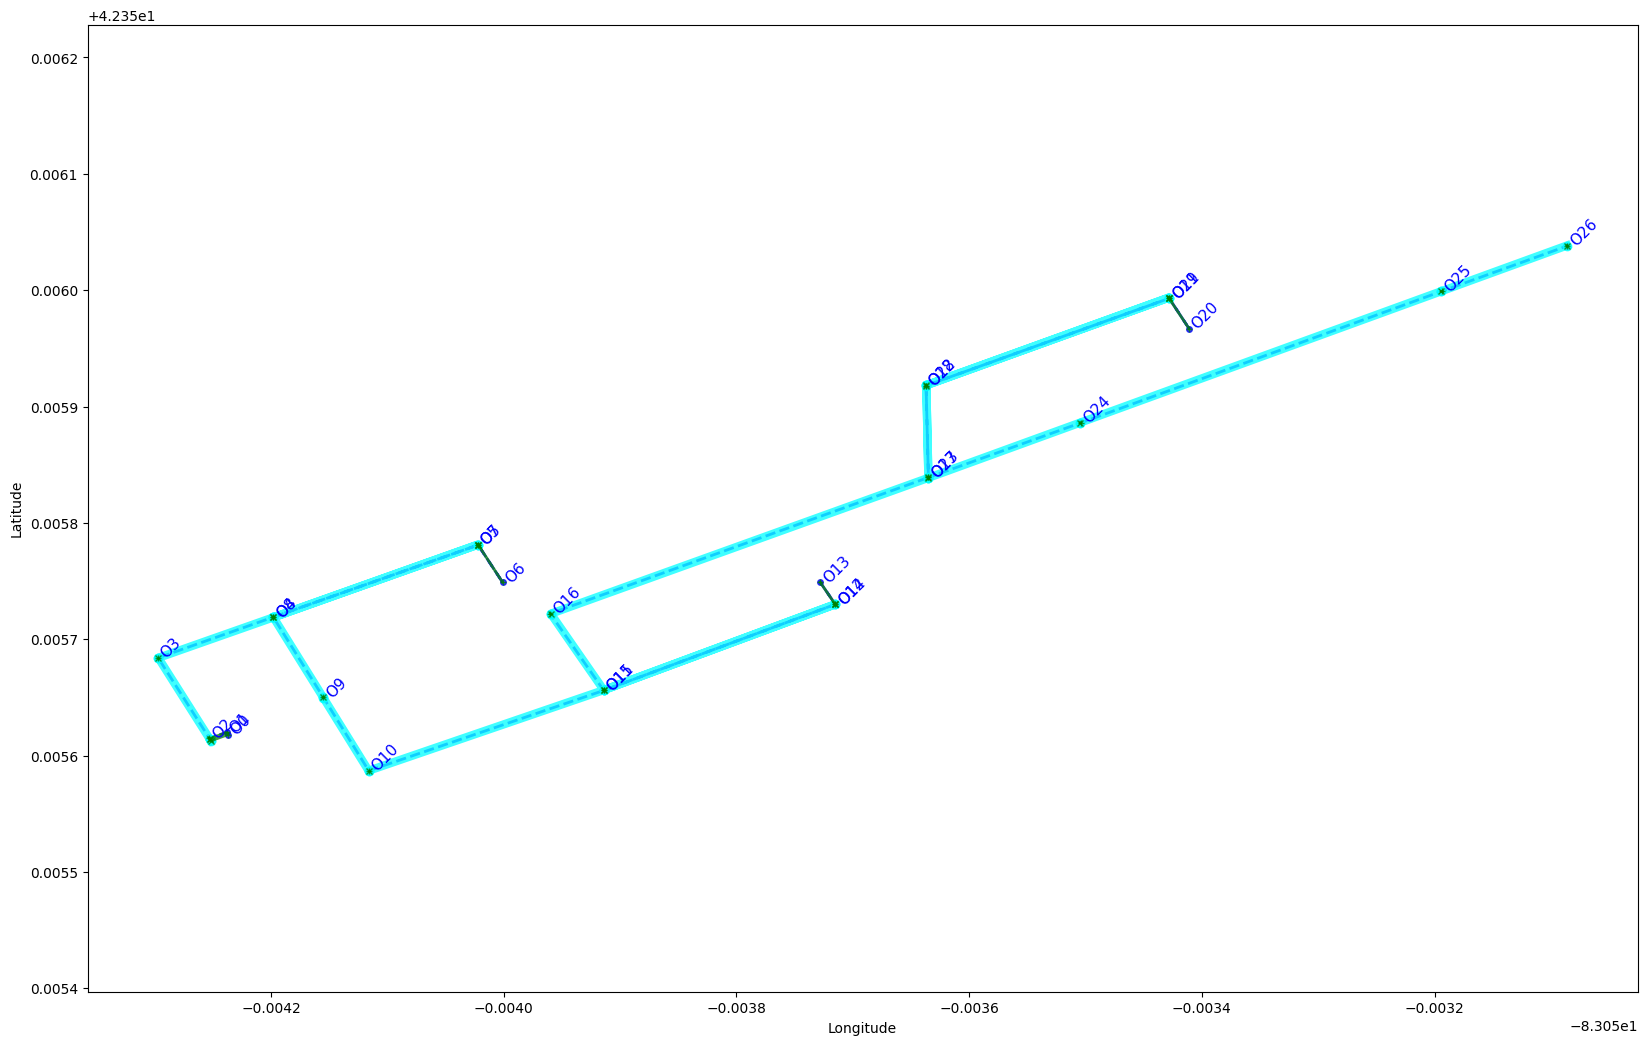

In [14]:
visualize(matchedModel, localNetwork, show_labels = True)